# Exploratory data analysis
Author: Michal Stary

This notebook consist of exploratory analysis of GC-MS data.

We work on train&val sets of already partitioned data in order to avoid any infection of test set information to our decision and training procedures. 

Table of Contents:
1. Peaks statistics
    1. Peak counts in spectra
    2. Peak occurence across whole dataset
    3. Peak intensities
        - intensities at kth peaks 
        - peaks at intensity bins
    4. Distribution of the intensities of the most common peaks across dataset
    
    
2. InChiKey statistics
    1. InChiKey duplicity
    3. InChiKey prefix duplicity
    
3. Similarity of different measures of same compound
    1. Visual inspection of different measurements

4. Structural similarity of compounds in dataset
  

In [1]:
base = "data"
dataset = "nist"
kind = "de_novo"

data_train_path =f"{base}/{dataset}/{kind}/train.msp"
data_val_path =f"{base}/{dataset}/{kind}/val.msp"
data_test_path =f"{base}/{dataset}/{kind}/test.msp"

max_mz = 1001

%load_ext autoreload
%autoreload 2

In [2]:
from matchms.importing import load_from_msp
from data_utils import spectrum_processing, get_n_samples
from helpers import get_mz_vector, get_his_size, compact_to_mz

import numpy as np
from matchms.importing import load_from_msp
from matchms.filtering import normalize_intensities

import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

## Data loading

In [3]:
def get_spectra(path):
    # Load data from MSP file and apply filters
    spectrums = [spectrum_processing(s, min_rel_int=None) for s in load_from_msp(path)]
    # Omit spectrums that didn't qualify for analysis
    spectrums = [s for s in spectrums if s is not None]
    # Create spectrum documents
    return spectrums
data = get_spectra(data_train_path)
# spectrums_val = get_spectra(data_val_path)
# spectrums_test = get_spectra(data_test_path)

In [4]:
data[19].peaks.mz, data[19].peaks.intensities

(array([12., 13., 14., 15., 24., 25., 26., 27., 28., 38., 39., 40., 41.,
        42.]),
 array([0.022002  , 0.01600601, 0.08700701, 0.01600601, 0.007998  ,
        0.02600601, 0.03700701, 0.023003  , 0.04      , 0.05900901,
        0.13201201, 0.45504505, 1.        , 0.01500501]))

In [62]:
len(data)

225077

## Plotting utils

In [63]:
sns.set_theme()
from visual_utils import plot_stats

## Peak statistics

### mz range

In [64]:
def get_mzs(data):
    return [rec.peaks.mz for rec in data]

mzs = get_mzs(data)
mzs[:5]

[array([10., 11., 12., 13., 14., 15., 21., 22., 23., 24., 25., 26., 27.,
        28.]),
 array([ 2., 12., 13., 14., 15., 24., 25., 26., 27., 28., 29., 30.]),
 array([12., 13., 14., 15., 24., 25., 26., 27., 28., 29.]),
 array([ 2., 12., 13., 14., 15., 16., 24., 25., 26., 27., 28., 29., 30.,
        31.]),
 array([12., 13., 14., 15., 16., 24., 25., 26., 27., 28., 29., 30., 31.])]

In [65]:
min_mz =min(map(lambda x: x.min(), mzs))
max_mz = max(map(lambda x: x.max(), mzs))
min_mz, max_mz

(1.0, 1000.0)

### mz granularity
Granularity of mz axis


In [66]:
# get number of peaks with higher than nominal precision
def get_higher(mzs):
    higher = 0
    for spect_mzs in mzs:
        higher += len(spect_mzs) - sum(map(lambda x: (x).is_integer(), spect_mzs))
    return higher
get_higher(mzs)

0

### Peak counts
Number of peaks in spectra

In [67]:
#number of peaks in spectra
def get_n_peaks(data):
    return np.array([len(rec.peaks.mz) for rec in data])
n_peaks = get_n_peaks(data)

In [68]:
print(max(n_peaks))
print(min(n_peaks))
print(n_peaks.mean())

741
10
104.94179325297564


In [69]:
val_c = pd.Series(n_peaks).value_counts() 
x = val_c.index
y = val_c

In [70]:
counts = np.zeros(max(x)+1, dtype=int)
for u in zip(x, y):
    counts[x] = y
cum_counts = np.cumsum(counts[::-1])[::-1]

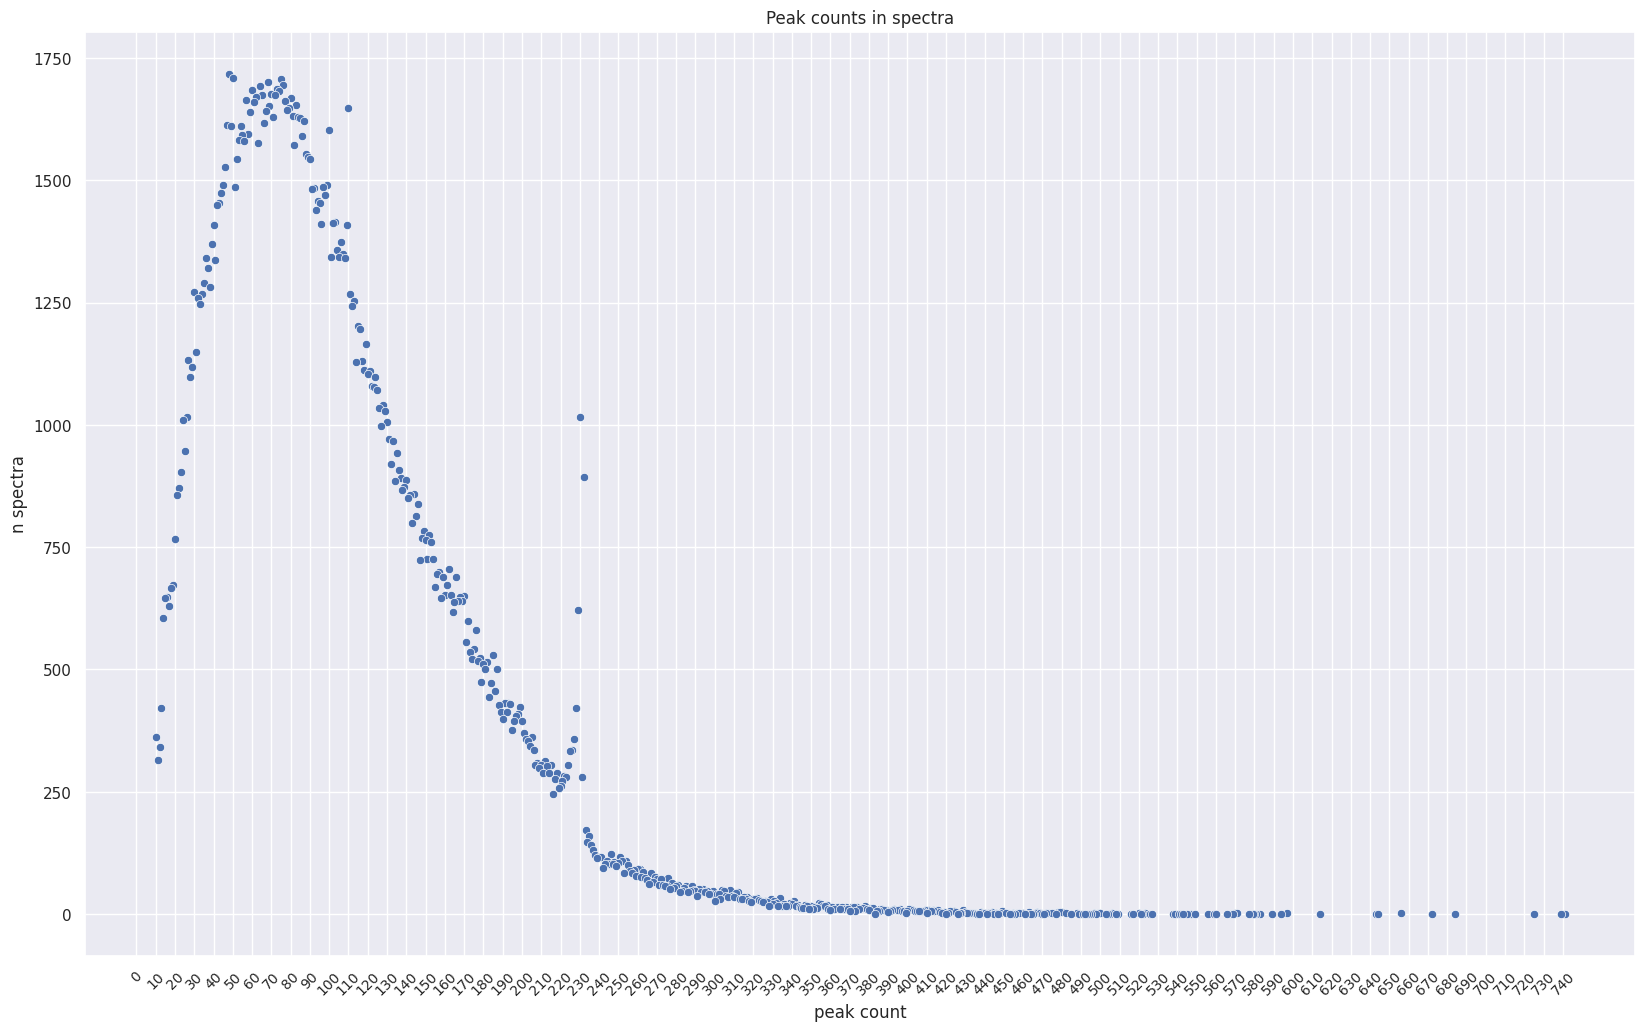

In [71]:
plt.figure(figsize=(20,12))
ax = sns.scatterplot(x=x, y=y)
plt.xticks(ticks=np.arange(0,(max(n_peaks)),10),fontsize=10, rotation=45)
plt.title("Peak counts in spectra")
ax.set(ylabel='n spectra', xlabel='peak count')
None

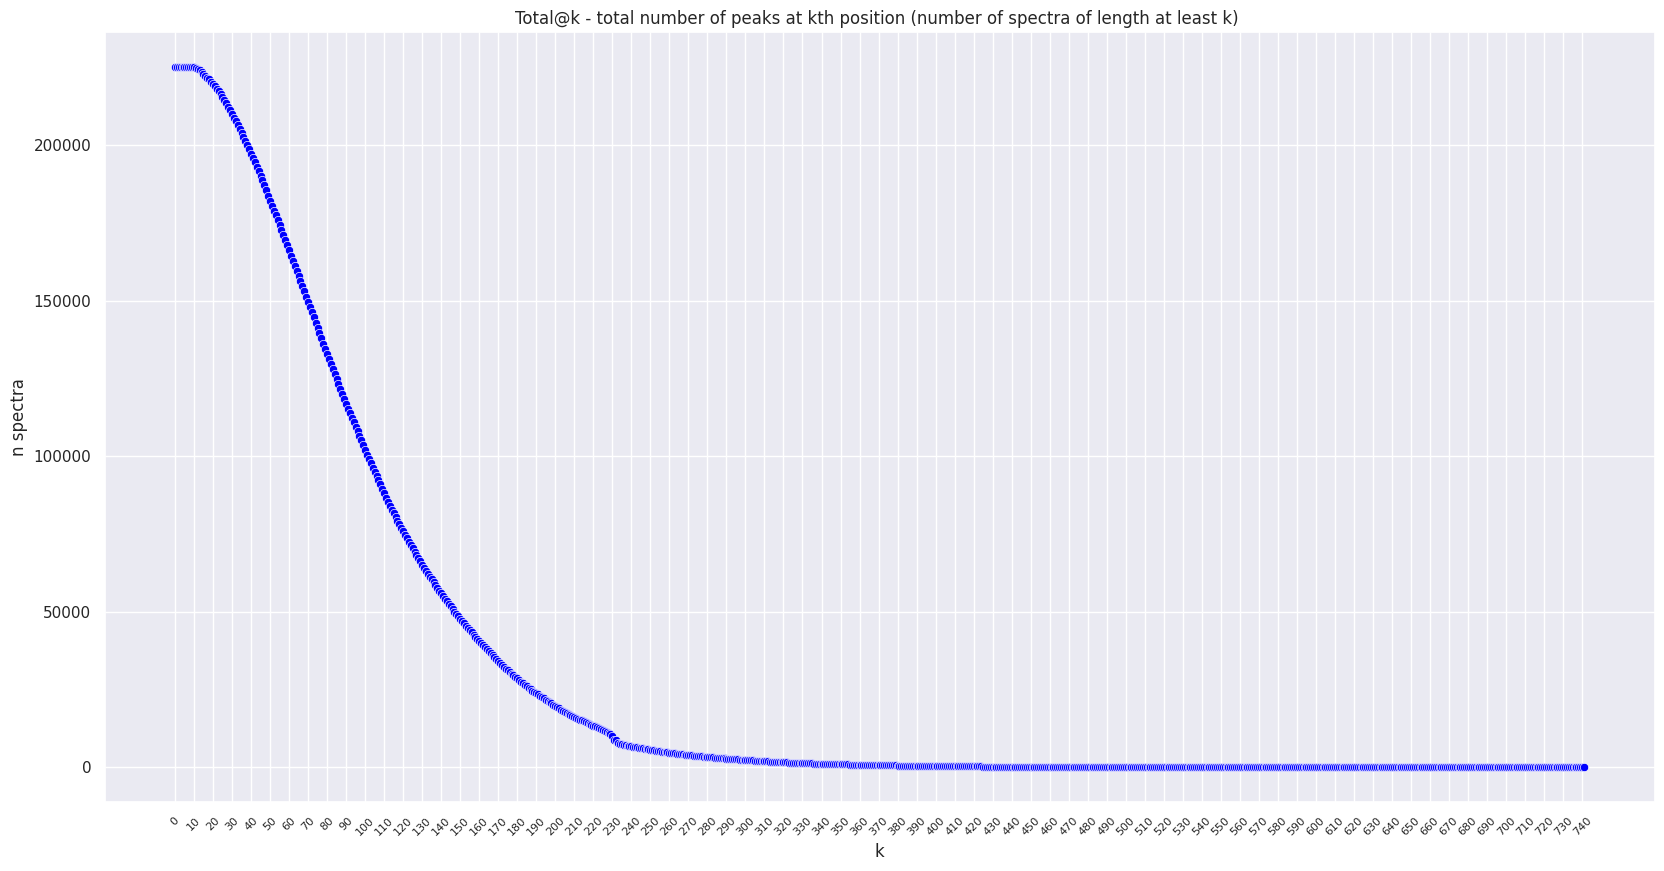

In [72]:
plot_stats(cum_counts, title="Total@k - total number of peaks at kth position (number of spectra of length at least k) ", ylabel='n spectra', xlabel='k')

### Peak occurence across whole dataset
Occurence of peaks in whole dataset

In [6]:
from collections import Counter
def get_occurence(data):
    all_ = []
    for i in range(len(data)):
        all_ += [*map(lambda p: int(p), data[i].peaks.mz)]
    return all_, Counter(all_)
all_, occurences = get_occurence(data)

locations, counts = np.array(sorted(zip(occurences.keys(), occurences.values() ), key=lambda x: x[0])).T
occurences.most_common(10),  min(all_), max(all_)

([(41, 186846),
  (43, 183563),
  (55, 183401),
  (77, 178981),
  (53, 178810),
  (39, 173801),
  (51, 173615),
  (69, 173507),
  (42, 170610),
  (57, 170019)],
 1,
 1000)

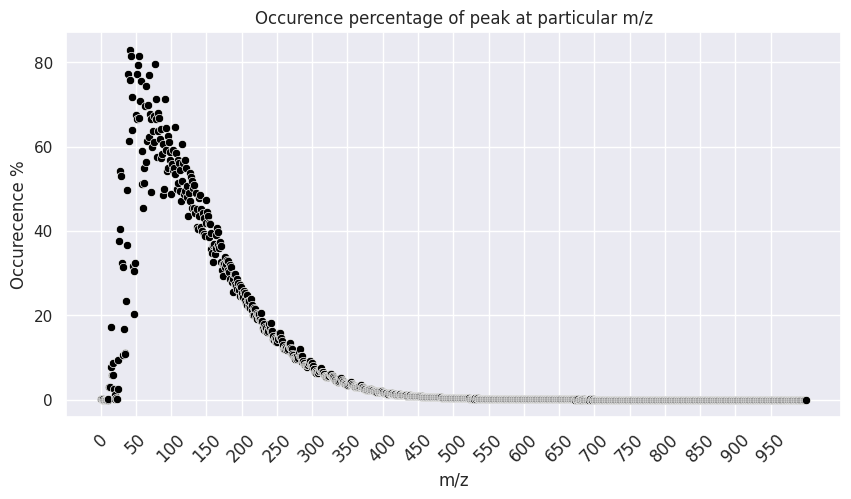

In [87]:
plt.figure(figsize=(10, 5))
# fig, (ax1, ax2) = plt.subplots(1,2)
ax = sns.scatterplot(x=locations, y=counts/len(data)*100, color="black")
plt.xticks(ticks=np.arange(0,1000,50), fontsize=12, rotation=45)
plt.title("Occurence percentage of peak at particular m/z")
ax.set(ylabel='Occurecence %', xlabel='m/z')

plt.savefig("figures/dataset/occurence.pdf", bbox_inches='tight')

In [114]:
perc75 = len(data)/100*75
perc50 = len(data)/100*50

p50 = 0 
for mz, val in occurences.most_common():
    if val > perc75:
        print(mz)
    if val> perc50:
        p50 +=1
        
print("d", p50)

41
43
55
77
53
39
51
69
42
57
d 77


### Peak intensities

#### Int@k
Mean intensity of peaks on kth position

In [75]:
def get_intensities(data):
    return [rec.peaks.intensities for rec in data]


def int_at_k(all_intensities):
    max_len = max(map( len, all_intensities))
    sum_ = np.zeros(max_len)
    counts = np.zeros(max_len)
    for intensities in all_intensities:
        for j, inten in enumerate(sorted(intensities, reverse=True)):
            sum_[j] += inten
            counts[j] += 1
    mean_inten_at_k = sum_/counts
    return mean_inten_at_k
mean_int_at_k = int_at_k(get_intensities(data))
mean_int_at_k[:10], mean_int_at_k[-10:]

(array([1.        , 0.58958849, 0.41118552, 0.31636672, 0.25744168,
        0.21721901, 0.18757586, 0.16486276, 0.14670743, 0.13191025]),
 array([0.0005005, 0.0005005, 0.0005005, 0.0005005, 0.0005005, 0.0005005,
        0.0005005, 0.0005005, 0.0005005, 0.0005005]))

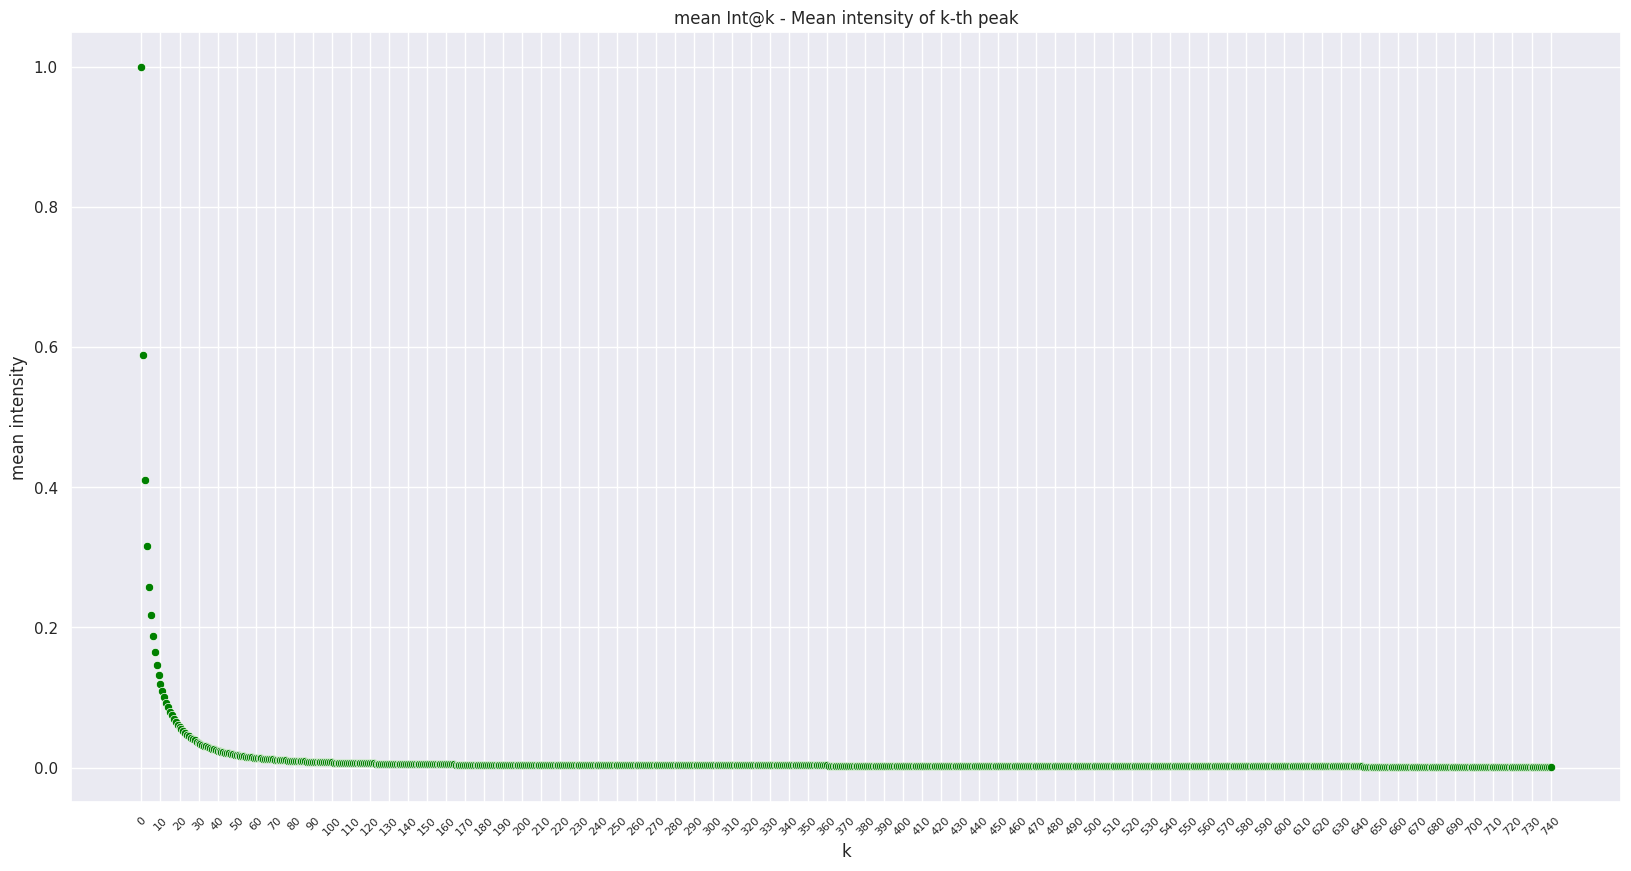

In [76]:
plot_stats(mean_int_at_k, title="mean Int@k - Mean intensity of k-th peak", color="green", ylabel='mean intensity', xlabel='k')

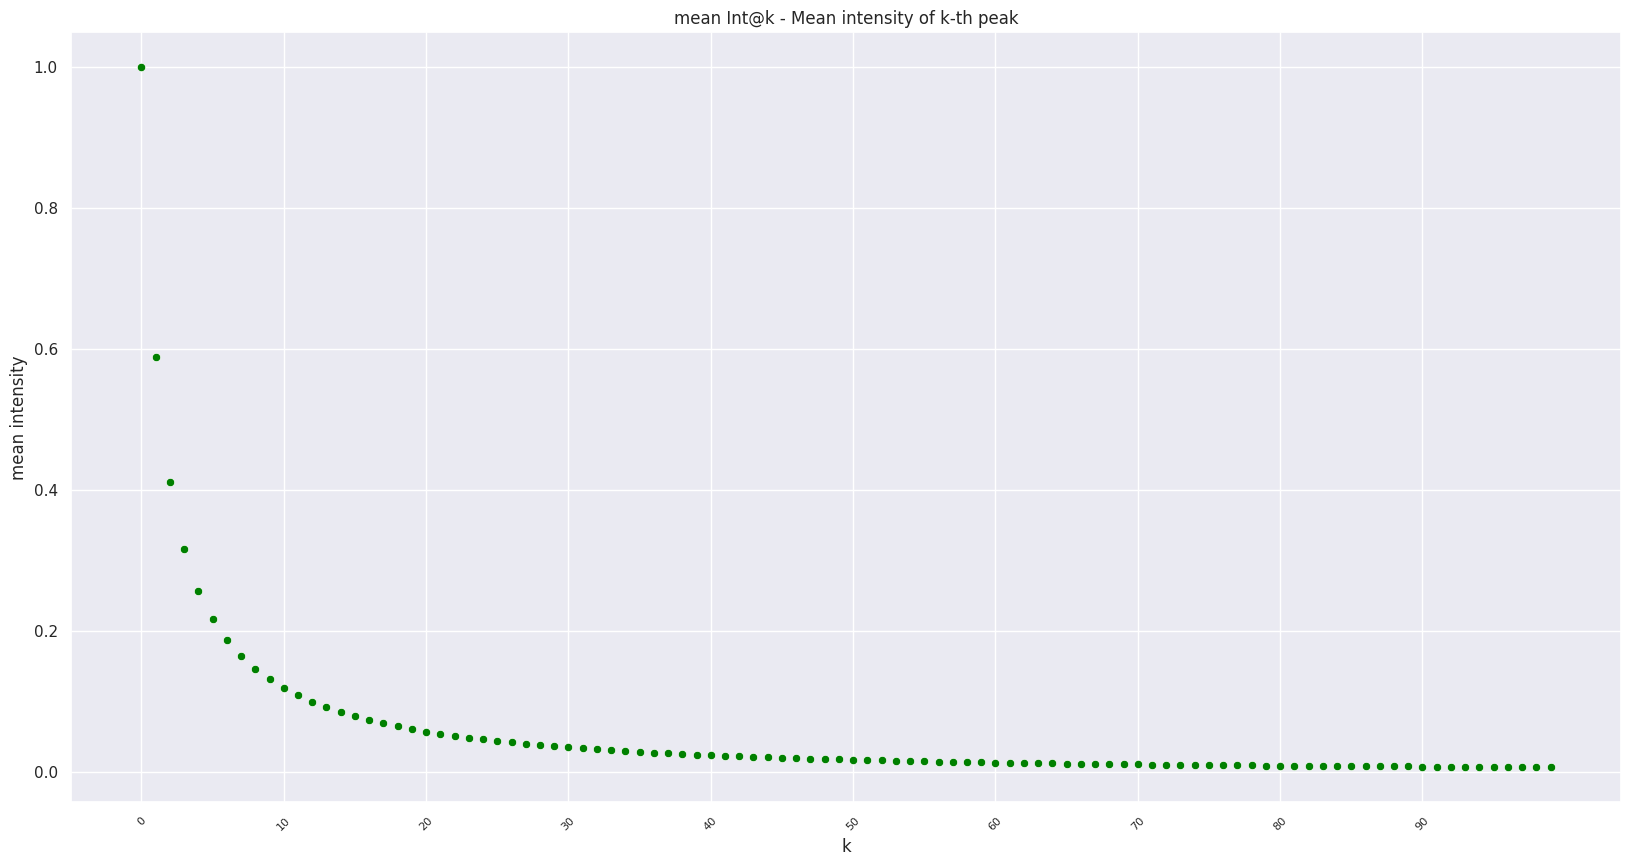

In [77]:
plot_stats(mean_int_at_k[:100], title="mean Int@k - Mean intensity of k-th peak", color="green", ylabel='mean intensity', xlabel='k')

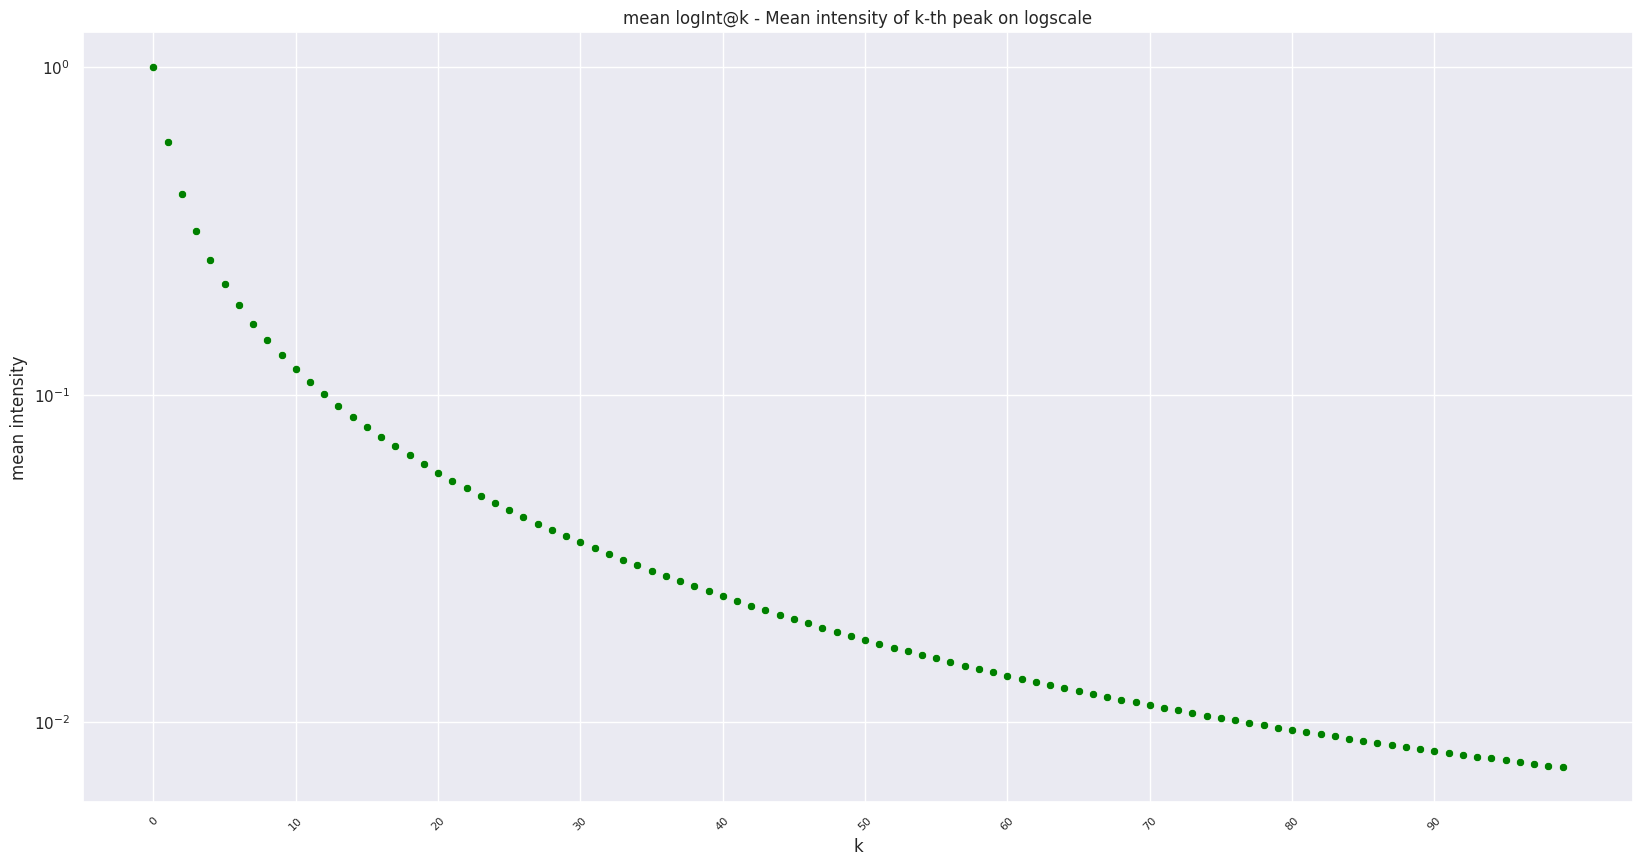

In [105]:
plot_stats(mean_int_at_k[:100], title="mean logInt@k - Mean intensity of k-th peak on logscale", log_y=True, color="green",ylabel='mean intensity', xlabel='k' )

### peaks@int
Total number of peaks of some intensity (=of some intensity bin)

In [22]:
def peaks_at_int(all_intensities, granularity, skip_k=0):
    max_len = int(1/granularity)
    total = np.zeros(max_len+1, dtype=int)
    for inten in all_intensities:
        for i in range(skip_k, len(inten)):
            #print(inten[i])
            total[int(inten[i]*max_len)] +=1 
    return total

peaks_at_int = peaks_at_int(get_intensities(data), .01, skip_k=0)
peaks_at_int[:10], peaks_at_int[-10:]

(array([11155850,  3521748,  1894168,  1206182,   854013,   642554,
          498800,   404132,   335137,   276365]),
 array([  3521,   3368,   3496,   3488,   3718,   3781,   3709,   3658,
          3149, 226062]))

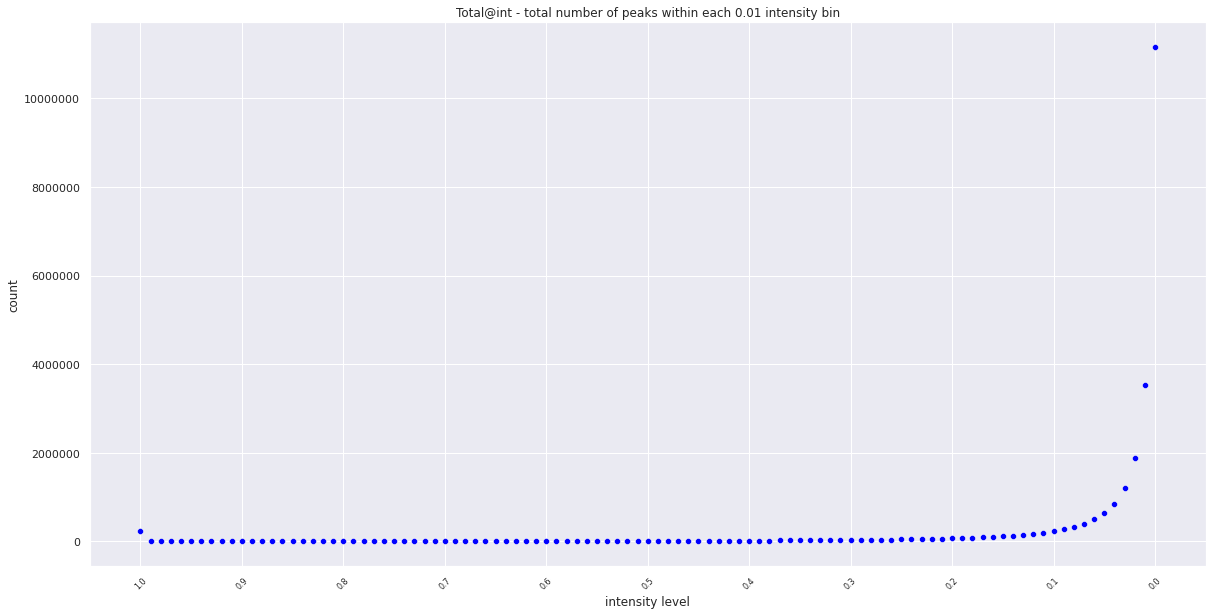

In [23]:
plot_stats(peaks_at_int, title="Total@int - total number of peaks within each 0.01 intensity bin", decreasing=True, ylabel='count', xlabel='intensity level', x_factor=0.01, disable_scientific=True)

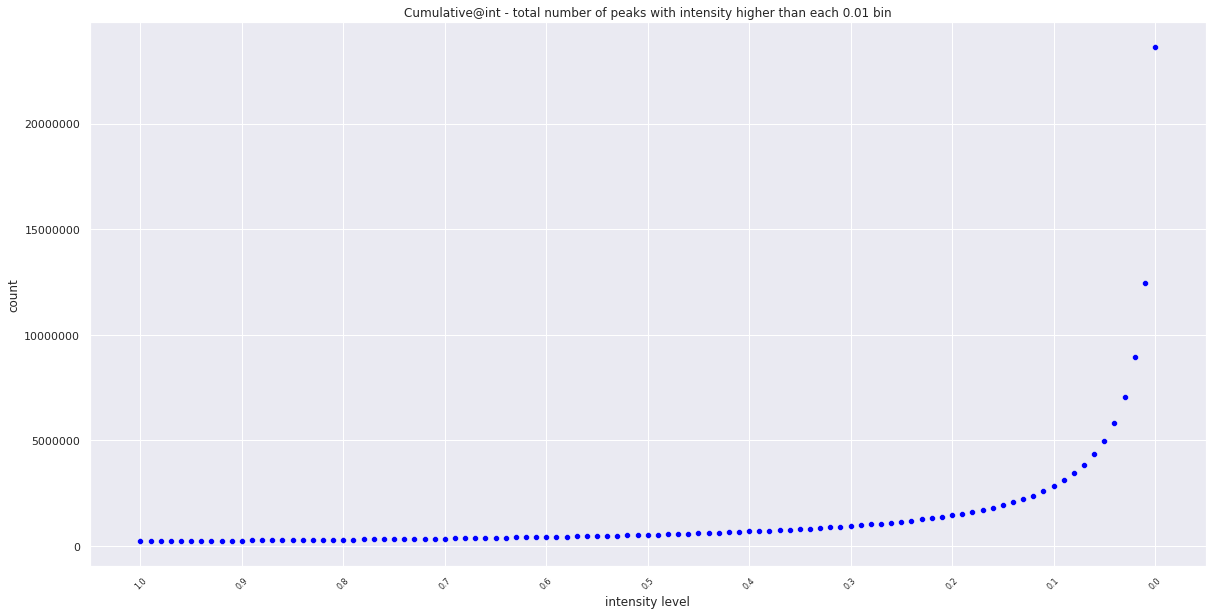

In [24]:
plot_stats(np.cumsum(peaks_at_int[::-1])[::-1], title="Cumulative@int - total number of peaks with intensity higher than each 0.01 bin", decreasing=True, ylabel='count', xlabel='intensity level', x_factor=0.01, disable_scientific=True)

### Distribution of the intensities of the most common peaks across dataset
Distribution of intensities of the most common peaks

To inspect closer the super frequent peaks - those in up to 80% of samples 

In [25]:
data[10].peaks.to_numpy

array([[1.20000000e+01, 1.30030030e-02],
       [1.30000000e+01, 2.50050050e-02],
       [1.40000000e+01, 5.10010010e-02],
       [1.50000000e+01, 2.47027027e-01],
       [1.70000000e+01, 1.50050050e-02],
       [1.80000000e+01, 1.30030030e-02],
       [2.80000000e+01, 4.90090090e-02],
       [2.90000000e+01, 5.11051051e-01],
       [3.00000000e+01, 6.90090090e-02],
       [3.10000000e+01, 1.00000000e+00],
       [3.20000000e+01, 7.36076076e-01],
       [3.30000000e+01, 1.60060060e-02]])

In [26]:
# peaks to intensities
def get_peak_ints(data):
    p_to_ints = [[] for _ in range(int(max_mz))]
    for rec in data:
        for mz, i in rec.peaks.to_numpy:
            p_to_ints[int(mz)-1] += [i]
            
    return p_to_ints

p_to_ints = get_peak_ints(data)

41 186846


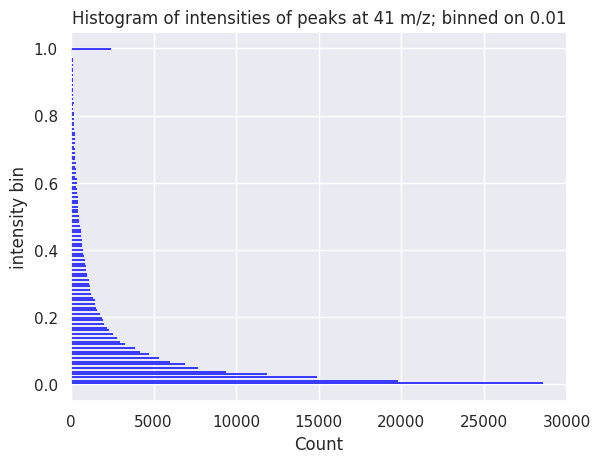

In [133]:
for p, c in occurences.most_common(1):
    print(p,c)
    ax = sns.histplot(y=(np.array(p_to_ints[p-1])*100).astype(int)/100, color="blue")
    assert len(p_to_ints[p-1]) == c
    plt.ylabel("intensity bin")
    plt.setp(ax.patches, linewidth=0)
    plt.title(f"Histogram of intensities of peaks at {p} m/z; binned on 0.01")
    plt.savefig("figures/dataset/most_common_int.pdf")
    plt.show()

## InChiKey statistics


#### Compound Duplicity  

In [20]:
def get_inchikey(data):
    return [rec.metadata["inchikey"] for rec in data]

inchikeys = get_inchikey(data)
Counter(inchikeys).most_common(10)

[('JLYXXMFPNIAWKQ-UHFFFAOYSA-N', 19),
 ('NOOLISFMXDJSKH-UHFFFAOYSA-N', 16),
 ('CFJYNSNXFXLKNS-UHFFFAOYSA-N', 12),
 ('NNBZCPXTIHJBJL-UHFFFAOYSA-N', 11),
 ('PSQYTAPXSHCGMF-BQYQJAHWSA-N', 11),
 ('RQEUFEKYXDPUSK-UHFFFAOYSA-N', 10),
 ('VNQXSTWCDUXYEZ-UHFFFAOYSA-N', 10),
 ('MBDOYVRWFFCFHM-SNAWJCMRSA-N', 9),
 ('UFLHIIWVXFIJGU-ARJAWSKDSA-N', 9),
 ('ZQTYQMYDIHMKQB-UHFFFAOYSA-N', 9)]

In [29]:
pd.DataFrame(data=list(Counter(inchikeys).items()), columns=["n_iks", "count"]).groupby("count").count()

,n_iks
count,
1,171368
2,11515
3,4472
4,2269
5,1119
6,297
7,69
8,14
9,14


#### Observation

#### Compound InchiPrefix Duplicity  

In [9]:
def get_inchikey_prefix(inchikeys):
    return [ik.split("-")[0] for ik in inchikeys]
prefixes = get_inchikey_prefix(inchikeys)
Counter(prefixes).most_common(10)

[('NOOLISFMXDJSKH', 24),
 ('DLNKOYKMWOXYQA', 19),
 ('NFLGAXVYCFJBMK', 19),
 ('JLYXXMFPNIAWKQ', 19),
 ('KGEKLUUHTZCSIP', 17),
 ('QYIXCDOBOSTCEI', 17),
 ('DTGKSKDOIYIVQL', 15),
 ('ZQTYQMYDIHMKQB', 14),
 ('KWGRBVOPPLSCSI', 14),
 ('XHXUANMFYXWVNG', 14)]

In [31]:
pd.DataFrame(data=list(Counter(prefixes).items()), columns=["n_iks", "count"]).groupby("count").count()

,n_iks
count,
1,167841
2,11984
3,4509
4,2277
5,1180
6,351
7,125
8,47
9,56


## Spectral similarity across different measurements of one compound 
We will use the most duplicative compounds to estimate how similar spectra are when measured independently

### Spectra visualisation

In [31]:
def get_data_of_n_most_duplicative(data, n, inchikeys):
    res = [[] for _ in range(n)]
    
    cntr = Counter(get_inchikey_prefix(inchikeys))
    n_most_dup = [x[0] for x in cntr.most_common(n)]
    for i in range(len(data)):
        prefix = data[i].metadata["inchikey"].split("-")[0]
        if prefix in n_most_dup:
            res[n_most_dup.index(prefix)] += [data[i]]
    return res
most_dup_data = get_data_of_n_most_duplicative(data, 20, inchikeys)

In [41]:
sns.color_palette("tab10")

def show_same(most_dup_data, jth_most_dup, max_shown):
    for i in range(min(len(most_dup_data[jth_most_dup]), max_shown)):
        most_dup_data[jth_most_dup][i].plot()

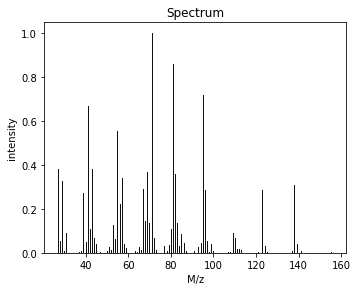

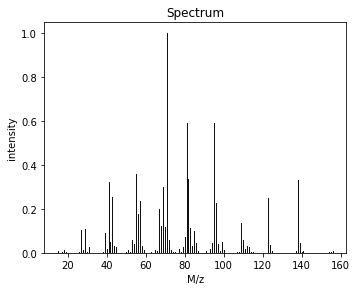

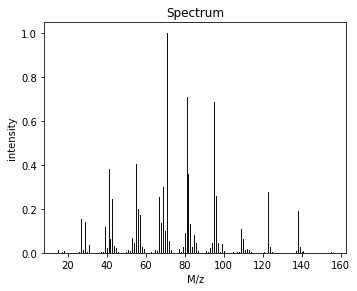

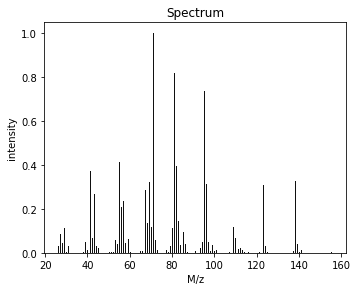

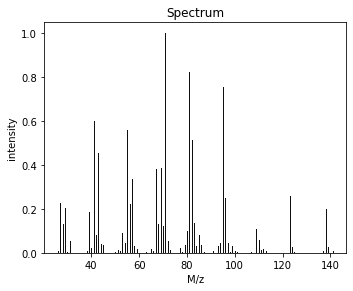

In [42]:
show_same(most_dup_data, 0, 5)

### Visual analysis of kth peaks

In [34]:
def visually_analyse_same(most_dup_data, jth_most_dup, up_to_k):
    for k in range(0,up_to_k):
        #plt.figure(figsize=(20,10))
        for rec in most_dup_data[jth_most_dup]:
            ins = rec.peaks.intensities
            mz = rec.peaks.mz
            kth = np.argsort(ins)[::-1][k:k+1]
            sns.scatterplot(x=mz[kth], y=ins[kth], s=200, alpha=.5)
        plt.title(f"Situation at {k+1}th peak")
        plt.show()
    for k in range(25,25+up_to_k):
        #plt.figure(figsize=(20,10))
        for rec in most_dup_data[jth_most_dup]:
            ins = rec.peaks.intensities
            mz = rec.peaks.mz
            kth = np.argsort(ins)[::-1][k:k+1]
            sns.scatterplot(x=mz[kth], y=ins[kth], s=200, alpha=.5)
        plt.title(f"Situation at {k+1}th peak")
        plt.show()
        

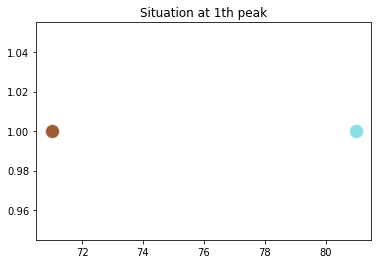

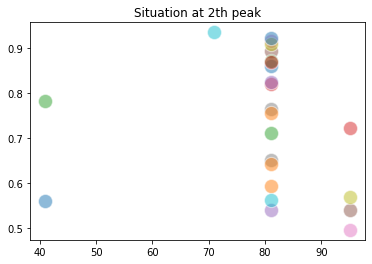

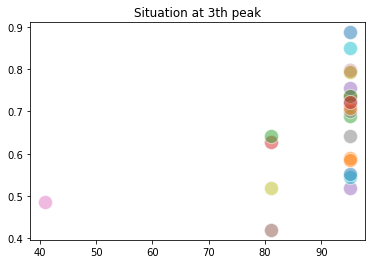

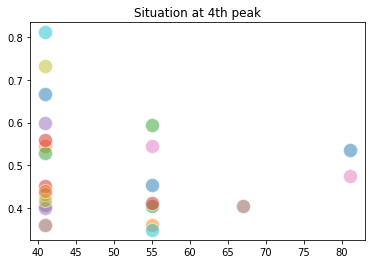

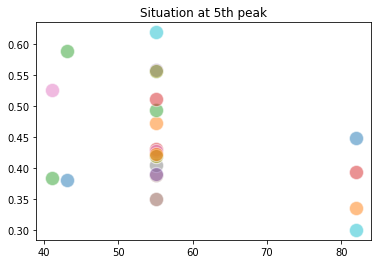

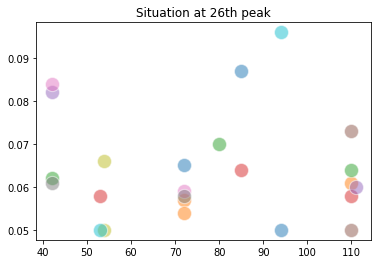

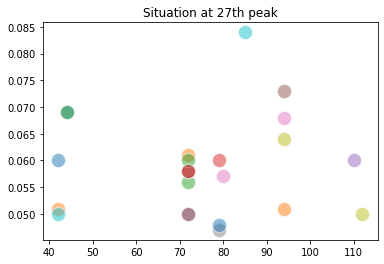

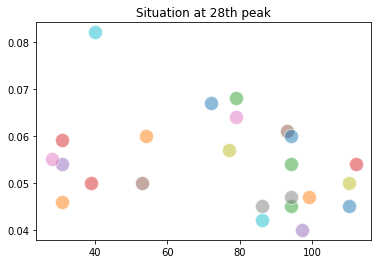

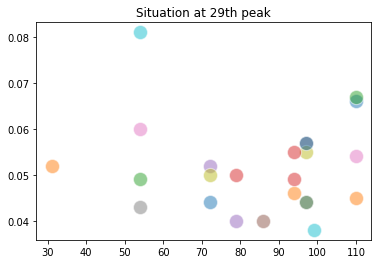

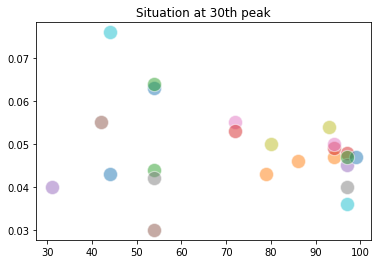

In [40]:
visually_analyse_same(most_dup_data, 0, 5)

## Structural similarity
we will use fingerprint jaccard score to asses the structural similarity of compounds

In [37]:
import numpy as np
from matchms import calculate_scores
from matchms import Spectrum
from matchms.filtering import add_fingerprint
from matchms.similarity import FingerprintSimilarity

def add_fingerprints_to_ds(ds):
    return [add_fingerprint(rec, nbits=2048) for rec in ds]

def get_tanimoto_scores(ds):
    similarity_measure = FingerprintSimilarity("jaccard")
    return similarity_measure.matrix(ds, ds, is_symmetric=True)

def get_n_samples(spectra, n):
    res = []
    nums = np.ones(len(spectra))
    nums[n:] = 0
    np.random.shuffle(nums)
    for i, sp in enumerate(spectra):
        if nums[i] == 1:
            res.append(sp)
            
    return res


selected = get_n_samples(data, 8000)

tanimoto_matrix = get_tanimoto_scores(add_fingerprints_to_ds(selected))
#tanimoto_matrix = np.nan_to_num(tanimoto_matrix)

RDKit ERROR: [12:06:22] Explicit valence for atom # 0 B, 5, is greater than permitted
RDKit ERROR: [12:06:22] Explicit valence for atom # 0 C, 5, is greater than permitted


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<Figure size 640x480 with 0 Axes>

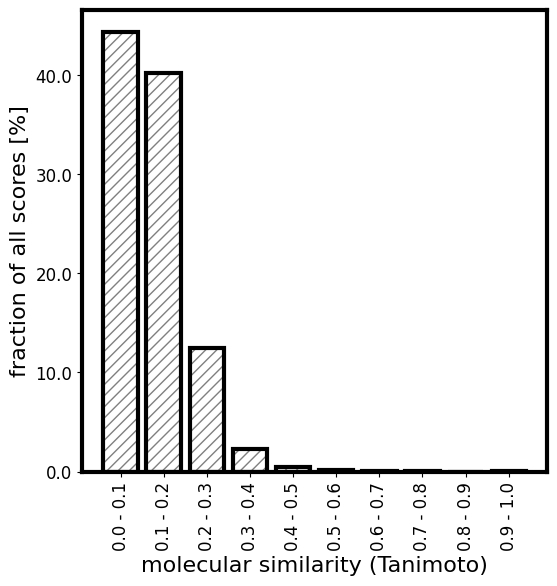

In [38]:
%load_ext autoreload
%autoreload 2
from spec2vec_plotting_functions import prepare_histogram_scores, plot_histogram

hist, bin_edges = prepare_histogram_scores(tanimoto_matrix, 10)
plot_histogram(hist, bin_edges, figsize=(6,6))